In [209]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()   # interactive mode


In [210]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [211]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((300,300)),
        transforms.GaussianBlur(5),
        transforms.ColorJitter(
            brightness=0.5,
            contrast=0.5,
            saturation=0.5
        ),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((300,300)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((300,300)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [212]:
# Split data into train - val - test
data_dir = '/content/drive/MyDrive/dataset_cropped/imgs_2class'
dataset = datasets.ImageFolder(data_dir)

def get_subset(indices, start, end):
    return indices[start : start + end]


TRAIN_PCT, VALIDATION_PCT = 0.6, 0.2  # rest will go for test
train_count = int(len(dataset) * TRAIN_PCT)
validation_count = int(len(dataset) * VALIDATION_PCT)

indices = torch.randperm(len(dataset))
subsets = {
    "train": get_subset(indices, 0, train_count),
    "val": get_subset(indices, train_count, validation_count),
    "test": get_subset(indices, train_count + validation_count, len(dataset))
}

dataloaders = {x :torch.utils.data.DataLoader(
                    datasets.ImageFolder(data_dir, data_transforms[x]), 
                    sampler=SubsetRandomSampler(subsets[x]),
                    batch_size=4, num_workers=2) 
                for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val', 'test']}
class_names = datasets.ImageFolder(data_dir).classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['mask', 'no_mask']


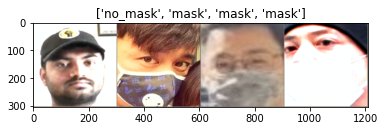

In [213]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [214]:
dataset_sizes

{'test': 196, 'train': 587, 'val': 196}

In [220]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test']:
            if phase == 'test':
                running_corrects = 0
                for inputs, labels in dataloaders['test']:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    running_corrects += torch.sum(preds == labels.data)
                epoch_acc = running_corrects.double() / (dataset_sizes['test']*4)
                print('TEST ACC: {:.4f}'.format(epoch_acc))
                # deep copy the model
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                break
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / (dataset_sizes[phase]*4)
            epoch_acc = running_corrects.double() / (dataset_sizes[phase]*4)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [216]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [217]:
def test_model(model):
  pass

In [218]:
model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[0] = nn.Dropout()
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [221]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=20)

Epoch 0/19
----------
train Loss: 0.1361 Acc: 0.9578
val Loss: 0.0891 Acc: 0.9707
TEST ACC: 0.9796

Epoch 1/19
----------
train Loss: 0.0723 Acc: 0.9779
val Loss: 0.0516 Acc: 0.9809
TEST ACC: 0.9770

Epoch 2/19
----------
train Loss: 0.0566 Acc: 0.9838
val Loss: 0.0580 Acc: 0.9809
TEST ACC: 0.9694

Epoch 3/19
----------
train Loss: 0.0289 Acc: 0.9911
val Loss: 0.0541 Acc: 0.9834
TEST ACC: 0.9821

Epoch 4/19
----------
train Loss: 0.0347 Acc: 0.9881
val Loss: 0.0538 Acc: 0.9834
TEST ACC: 0.9796

Epoch 5/19
----------
train Loss: 0.0217 Acc: 0.9940
val Loss: 0.0443 Acc: 0.9821
TEST ACC: 0.9834

Epoch 6/19
----------
train Loss: 0.0096 Acc: 0.9966
val Loss: 0.0418 Acc: 0.9847
TEST ACC: 0.9847

Epoch 7/19
----------
train Loss: 0.0107 Acc: 0.9953
val Loss: 0.0438 Acc: 0.9834
TEST ACC: 0.9847

Epoch 8/19
----------
train Loss: 0.0079 Acc: 0.9970
val Loss: 0.0493 Acc: 0.9834
TEST ACC: 0.9834

Epoch 9/19
----------
train Loss: 0.0071 Acc: 0.9970
val Loss: 0.0435 Acc: 0.9860
TEST ACC: 0.9847



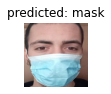

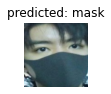

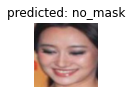

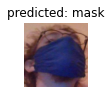

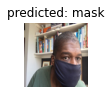

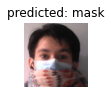

In [224]:
#why the model tests perfectly, when training claims 4% accuracy is beyond my comprehension
visualize_model(model_ft)

In [222]:
PATH = '/content/mnv2_mask_classifier_v4.pth'
torch.save(model_ft, PATH)